In [37]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
#!pip install transformers

In [54]:
from datasets import load_dataset
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spacy.scorer import Scorer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler
from tqdm import tqdm
from torch.optim import AdamW
import pickle
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix 
import seaborn as sns 

In [2]:
def process_text(text):
    ''' Process the text: lowercasing, lemmatization, stopwords removal, 
        and punctuation removal
        Input: text: the text to be processed'''
    text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('  ', ' ')

    # Word tokenization 
    tokens = word_tokenize(text)

    # Normalization (lowercasing and lemmatization)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Token filtering (stopwords removal)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove punctuation tokens
    tokens = [token for token in tokens if token.isalpha()]

    # Join the tokens back into a string
    text = ' '.join(tokens)

    return text

In [3]:
def plot_classes_distribution(labels, num_samples_per_class, title):
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.barh(labels, num_samples_per_class)
    plt.xlabel("Number of samples")
    plt.ylabel("Class")
    plt.title(title)
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.show()

In [4]:
# Load the dataset
dataset = load_dataset("argilla/medical-domain")

as a recap from exericse one, let's have a look again at the classes

In [5]:
def basic_statistics(dataset):
    num_samples = len(dataset['train']) 
    
    # Number of classes
    labels = []
    for sample in dataset['train']['prediction']:
        label = sample[0]['label']
        if label not in labels:
            labels.append(label)
    
    num_classes = len(labels)
    num_samples_per_class=[]
    for label in labels:
        num_samples_per_class.append(len(dataset['train'].filter(lambda example: example['prediction'][0]['label'] == label)))

    return num_samples, labels, num_classes, num_samples_per_class

In [6]:
num_samples, labels, num_classes, num_samples_per_class = basic_statistics(dataset)

In [7]:
print("Number of samples before filtering: ", num_samples)
print("Number of classes before filtering: ", num_classes)

Number of samples before filtering:  4966
Number of classes before filtering:  40


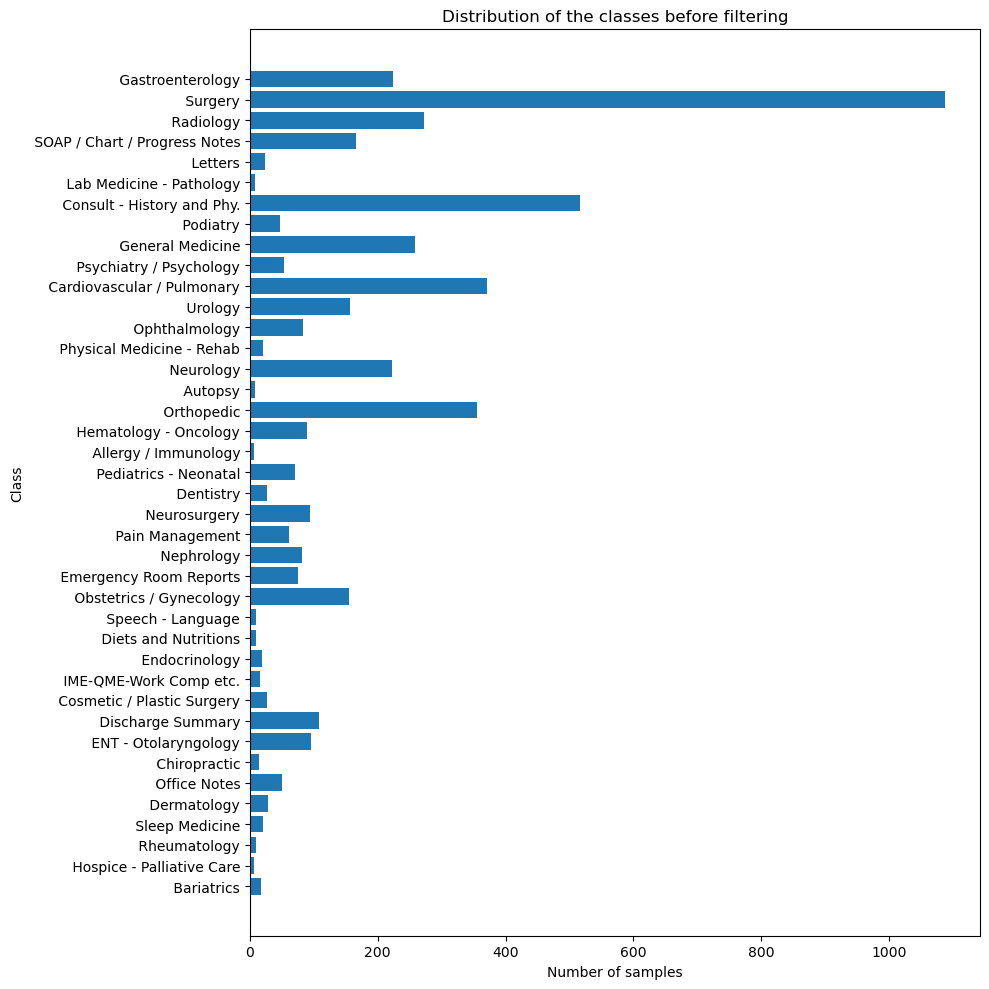

In [8]:
# plot the distribution of the classes
plot_classes_distribution(labels, num_samples_per_class, "Distribution of the classes before filtering")

In [9]:
#Filter classes which are too small
min_num_samples=30
filtered_classes = np.array(labels)[np.array(num_samples_per_class)>min_num_samples]
dataset['train'] = dataset['train'].filter(lambda sample: sample['prediction'][0]['label'] in filtered_classes)

In [10]:
num_samples, labels, num_classes, num_samples_per_class = basic_statistics(dataset)

In [11]:
print("Number of samples after filtering: ", num_samples)
print("Number of classes after filtering: ", num_classes)

Number of samples after filtering:  4694
Number of classes after filtering:  23


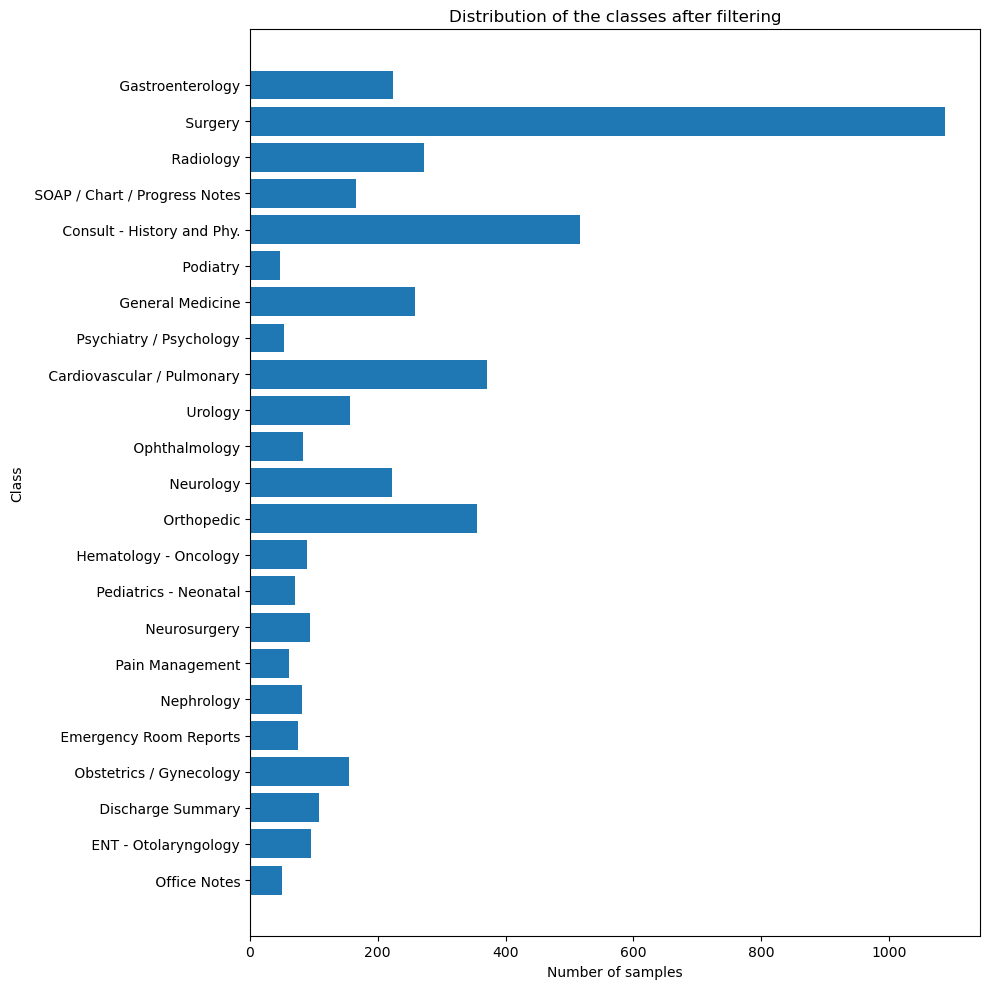

In [12]:
# plot the distribution of the classes after filtering
plot_classes_distribution(labels, num_samples_per_class, "Distribution of the classes after filtering")

Next we are going to set the environment that we created in Task 1 for the preprocessing of the text using the pipeline provided in our Task 1 notebook. 

In [13]:
# preprocess the data
dataset_p = pd.DataFrame(columns=['tokens', 'label'])
for i in range(len(dataset['train'])):
    text = dataset['train'][i]['text']
    label = dataset['train'][i]['prediction'][0]['label']
    text_p = process_text(text)
    dataset_p.loc[i] = [text_p, label]

In [14]:
dataset_p.head()

,tokens,label
0,preoperative diagnosis iron deficiency postope...,Gastroenterology
1,clinical indication normal stress procedure pe...,Surgery
2,finding scan performed reformatted image obtai...,Radiology
3,preoperative diagnosis blood loss postoperativ...,Surgery
4,reason visit elevated psa nocturia occasional ...,SOAP / Chart / Progress Notes


In [15]:
#convert labels to numbers
label2idx = {}
idx2label = {}
for i, label in enumerate(dataset_p['label'].unique()):
    label2idx[label] = i
    idx2label[i] = label

dataset_p['label'] = dataset_p['label'].map(label2idx)
dataset_p.head()


,tokens,label
0,preoperative diagnosis iron deficiency postope...,0
1,clinical indication normal stress procedure pe...,1
2,finding scan performed reformatted image obtai...,2
3,preoperative diagnosis blood loss postoperativ...,1
4,reason visit elevated psa nocturia occasional ...,3


In [16]:
#how many labels are there
print(len(dataset_p['label'].unique()))
dataset_p['label'].value_counts().sort_index()

23


label
0      224
1     1088
2      273
3      166
4      516
5       47
6      259
7       53
8      371
9      156
10      83
11     223
12     355
13      90
14      70
15      94
16      61
17      81
18      75
19     155
20     108
21      96
22      50
Name: count, dtype: int64

In [17]:
#wnat to use clinicalBERT for classification -> use its tokenizer
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")

In [18]:
## playing around with the tokenization
# apply tokenize on a sample and check the output
sample = dataset_p["tokens"][0]

print("Sample text before tokenization: ", sample)
# apply tokenization directly on the sample
# sample = tokenize(sample)
tokens = process_text(sample)
print(tokens)
sample = tokenizer.encode(sample)
print("Sample text after tokenization: ", tokenizer.convert_ids_to_tokens(sample))

Sample text before tokenization:  preoperative diagnosis iron deficiency postoperative diagnosis procedure medication procedure olympus pediatric variable colonoscope wa introduced rectum advanced carefully colon cecum identified ileocecal valve appendiceal orifice preparation wa good although wa residual material cecum wa difficult clear completely mucosa wa normal throughout colon polyp lesion identified blood wa noted diverticulum seen sigmoid colon luminal narrowing evidence inflammation retroflex view anorectal junction showed hemorrhoid patient tolerated procedure well wa sent recovery final diagnosis diverticulosis otherwise normal colonoscopy recommendation follow x screening colonoscopy additional evaluation cause anemia may appropriate
preoperative diagnosis iron deficiency postoperative diagnosis procedure medication procedure olympus pediatric variable colonoscope wa introduced rectum advanced carefully colon cecum identified ileocecal valve appendiceal orifice preparation 

In [19]:
# get max length of the tokens

idx = dataset_p["tokens"].apply(len).idxmax()

# Get that row
len(dataset_p.iloc[idx]["tokens"])

9731

In [20]:
# Function to return the length of tokenized text
#use BERT tokens or normal tokens?
def count_tokens_bert(text):
    return len(tokenizer.encode(text))


def count_tokens(text):
    return len(text.split())


# Apply the function to each row and find the maximum length
token_lengths = dataset_p["tokens"].apply(count_tokens)
max_token_length = max(token_lengths)

print("Maximum number of tokens in a single row:", max_token_length)

Maximum number of tokens in a single row: 1342


the max nb of tokens that BERT can take is 512, so this entry will be truncated to 512 tokens

In [21]:
token_lengths = dataset_p["tokens"].apply(count_tokens)

In [22]:
# how many tokens have lenght > 512
token_lengths[token_lengths > 512].count() / len(token_lengths)

0.0881976991904559

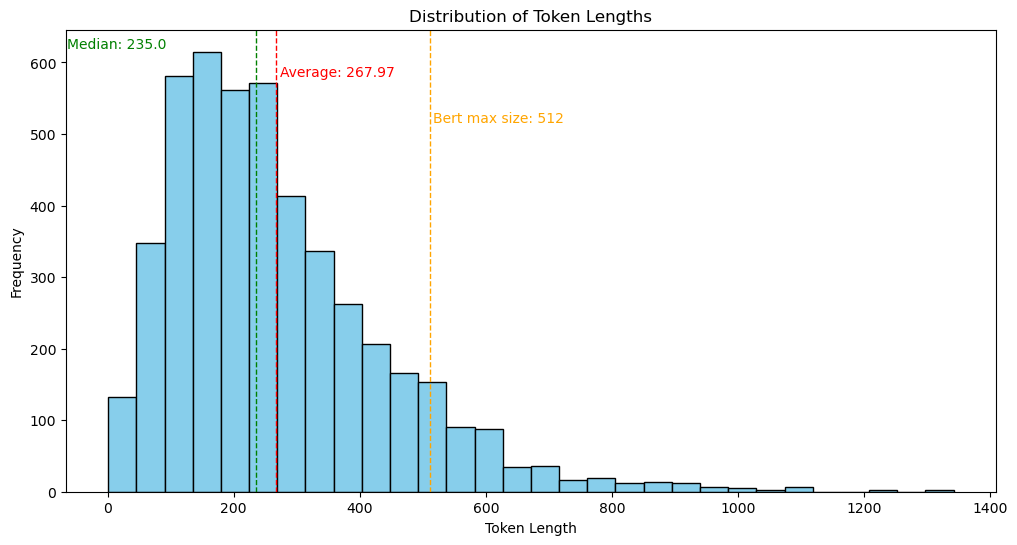

In [23]:
average_token_length = token_lengths.mean()
median_token_length = token_lengths.median()
bert_max_size = 512

# Plotting
plt.figure(figsize=(12, 6))
plt.hist(token_lengths, bins=30, color="skyblue", edgecolor="black")
plt.axvline(average_token_length, color="red", linestyle="dashed", linewidth=1)
plt.axvline(median_token_length, color="green", linestyle="dashed", linewidth=1)
plt.axvline(bert_max_size, color="orange", linestyle="dashed", linewidth=1)
plt.title("Distribution of Token Lengths")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.text(
    average_token_length + 5,
    plt.ylim()[1] * 0.9,
    f"Average: {average_token_length:.2f}",
    color="red",
)
plt.text(
    median_token_length - 300,
    plt.ylim()[1] * 0.96,
    f"Median: {median_token_length}",
    color="green",
)
plt.text(
    bert_max_size + 5,
    plt.ylim()[1] * 0.8,
    f"Bert max size: {bert_max_size}",
    color="orange",
)

plt.show()

In [24]:
# split rows that have more than 512 tokens into multiple rows to not lose data
def split_text(text, max_length):
    # Tokenize the text into words (not BERT tokens)
    words = text.split()

    # Split words into chunks of max_length
    chunks = [
        " ".join(words[i : i + max_length]) for i in range(0, len(words), max_length)
    ]
    return chunks

In [25]:
max_length = 512 - 2  # accounting for [CLS] and [SEP]

new_rows = []
for _, row in dataset_p.iterrows():
    text_chunks = split_text(row["tokens"], max_length)
    for chunk in text_chunks:
        new_rows.append({"tokens": chunk, "label": row["label"]})

# Create a new DataFrame
split_dataset_p = pd.DataFrame(new_rows)

In [26]:
token_lengths = split_dataset_p["tokens"].apply(count_tokens)


In [27]:
max_token_length = max(token_lengths)
print("Maximum number of tokens in a single row:", max_token_length)

Maximum number of tokens in a single row: 510


the average length is 428 tokens and the median is 369, so truncating to 512 should be fine. however, in this case 30% of the entries will be truncated

#TODO: adjust based on filtering

In [28]:
def tokenize(sent):
    encoded = tokenizer.encode_plus(
        text=sent,
        add_special_tokens=True,
        max_length=512,
        truncation=True,
        padding="max_length",
        return_attention_mask=True,
        return_tensors="pt",
    )
    return {
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"],
    }

In [29]:
train_df, eval_df = train_test_split(split_dataset_p, test_size=0.2, stratify=torch.tensor(split_dataset_p["label"].values))

train_encodings = train_df["tokens"].apply(lambda x: tokenize(x))
eval_encodings = eval_df["tokens"].apply(lambda x: tokenize(x))

train_labels = torch.tensor(train_df["label"].values)
eval_labels = torch.tensor(eval_df["label"].values)

train_inputs = torch.cat(
    train_encodings.apply(lambda x: x["input_ids"]).tolist(), dim=0
)
train_masks = torch.cat(
    train_encodings.apply(lambda x: x["attention_mask"]).tolist(), dim=0
)

eval_inputs = torch.cat(eval_encodings.apply(lambda x: x["input_ids"]).tolist(), dim=0)
eval_masks = torch.cat(
    eval_encodings.apply(lambda x: x["attention_mask"]).tolist(), dim=0
)

In [30]:
#get a weight per sample based on the label: label_weight = 1/ (num_classes * num_samples_per_class[class_label])   
weight_samples=1/(torch.index_select(torch.tensor(num_samples_per_class),0,train_labels)*num_classes)

In [31]:
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
eval_dataset = TensorDataset(eval_inputs, eval_masks, eval_labels)

#train_sampler = RandomSampler(train_dataset)
train_sampler = WeightedRandomSampler(weight_samples, num_samples=train_labels.shape[0], replacement=False)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=32)

eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=4)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")	

In [33]:
model = AutoModelForSequenceClassification.from_pretrained(
    "medicalai/ClinicalBERT",
    num_labels=40,
)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [56]:
def evaluate(model, dataloader): 

    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch_inputs, batch_masks, batch_labels = batch
            batch_inputs = batch_inputs.to(device)
            batch_masks = batch_masks.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_inputs, attention_mask=batch_masks)
            logits = outputs.logits

            logits = logits.detach().cpu().numpy()
            label_ids = batch_labels.to("cpu").numpy()

            predictions.append(logits)
            true_labels.append(label_ids)

    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(true_labels, predictions)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        true_labels, predictions, average="macro"
    )
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        true_labels, predictions, average="micro"
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        true_labels, predictions, average="weighted"
    )

    return {"accuracy": accuracy, "precision_macro": precision_macro, "recall_macro": recall_macro, "f1_macro": f1_macro, "precision_micro": precision_micro, "recall_micro": recall_micro, "f1_micro": f1_micro, "precision_weighted": precision_weighted, "recall_weighted": recall_weighted, "f1_weighted": f1_weighted}

In [35]:
num_epochs = 0
max_patience=5
patience = max_patience
best_f1 = 0
optimizer = AdamW(model.parameters(), lr=5e-5)
it = 0
# Create tensorboard
summary = SummaryWriter("./", purge_step=0)

epoch_length = len(train_dataloader)

from tqdm import tqdm

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch + 1}/{num_epochs}...")
    model.train()

    for batch in tqdm(train_dataloader):
        it += 1
        batch_inputs, batch_masks, batch_labels = batch
        batch_inputs = batch_inputs.to(device)
        batch_masks = batch_masks.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_inputs, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        if (it % (epoch_length/8)) == 0:
            summary.add_scalar("training loss", loss.cpu().item(), it)  

    model.eval()
    eval_metrics = evaluate(model, eval_dataloader)
    for key in eval_metrics:
        summary.add_scalar(key, eval_metrics[key], epoch +1)
        
    f1 = eval_metrics['f1_weighted']            
    
    if best_f1 < f1:
        patience = max_patience
        best_f1=f1
        torch.save(model.state_dict(), "best_model.pt")

    else:
        patience -= 1
    
    print(f"My remaining patience is {patience}.") 
    print(f"Current f1 score is {f1}")
    print(f"Current loss is {loss.cpu().item()}")
    if patience <= 0:
        print("My patience run out.") 
        break
        
print("Training finished with " + str(num_epochs) + " epochs")  
            

Training finished with 0 epochs


In [50]:
model.load_state_dict(torch.load("best_model.pt", map_location=torch.device('cpu')))
eval_metrics = evaluate(model, eval_dataloader)
print(
    f"Validation Results - Accuracy: {eval_metrics['accuracy']:.3f}, Precision: {eval_metrics['precision']:.3f}, Recall: {eval_metrics['recall']:.3f}, F1: {eval_metrics['f1']:.3f}"
)

KeyboardInterrupt: 

copied from ubelix:

#### with preprocessing:

Validation Results - Accuracy: 0.336, Precision: 0.295, Recall: 0.336, F1: 0.303

#### without preprocessing (tokenization only):

Validation Results - Accuracy: 0.311, Precision: 0.266, Recall: 0.311, F1: 0.279

#### with preprocessing and splitting rows > 512 tokens:
Validation Results - Accuracy: 0.338, Precision: 0.290, Recall: 0.338, F1: 0.275

In [ ]:
# load predictions and true labels and plot
with open("model_evaluation_data_project.pkl", "rb") as handle:
    dict_pp = pickle.load(handle)

y_test_pp = dict_pp["true_labels"]
preds_pp = dict_pp["predictions"]
print(dict_pp.keys())

In [ ]:
with open("model_evaluation_data_project_tokenizer_only.pkl", "rb") as handle:
    dict_nopp = pickle.load(handle)

##compare to model without preprocessing
y_test_nopp = dict_nopp["true_labels"]
preds_nopp = dict_nopp["predictions"]



In [ ]:
with open("model_evaluation_data_project_split_rows.pkl", "rb") as handle:
    dict_split = pickle.load(handle)

##compare to model without preprocessing
y_test_split = dict_split["true_labels"]
preds_split = dict_split["predictions"]

In [51]:
with open("model_evaluation_data_project_split_rows_with_pp.pkl", "rb") as handle:
    dict_split_pp = pickle.load(handle)

##compare to model without preprocessing
y_test_split_pp = dict_split_pp["true_labels"]
preds_split_pp = dict_split_pp["predictions"]

In [52]:
labels= dataset_p['label'].unique().tolist()
labels

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22]

In [ ]:
# Assuming true_labels and predictions are your labels and predictions
cm = confusion_matrix(y_test_pp, preds_pp)

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=idx2label.values(),
    yticklabels=idx2label.values(),
)
plt.title("Confusion Matrix with preprocessing")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [ ]:
# Normalized Confusion Matrix
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=idx2label.values(),
    yticklabels=idx2label.values(),
)
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [ ]:
cm = confusion_matrix(y_test_nopp, preds_nopp)

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=idx2label.values(),
    yticklabels=idx2label.values(),
)
plt.title("Confusion Matrix without preprocessing")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [ ]:
# Assuming true_labels and predictions are your labels and predictions
cm = confusion_matrix(y_test_split, preds_split)

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=idx2label.values(),
    yticklabels=idx2label.values(),
)
plt.title("Confusion Matrix with preprocessing and splitting texts")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

confusion matrix without the splitting looks better to me. here it seems that the model learnt that there are many surgery cases and no mostly predicts surgery, independent of the actual label.


TODO: how to deal with class imbalance?

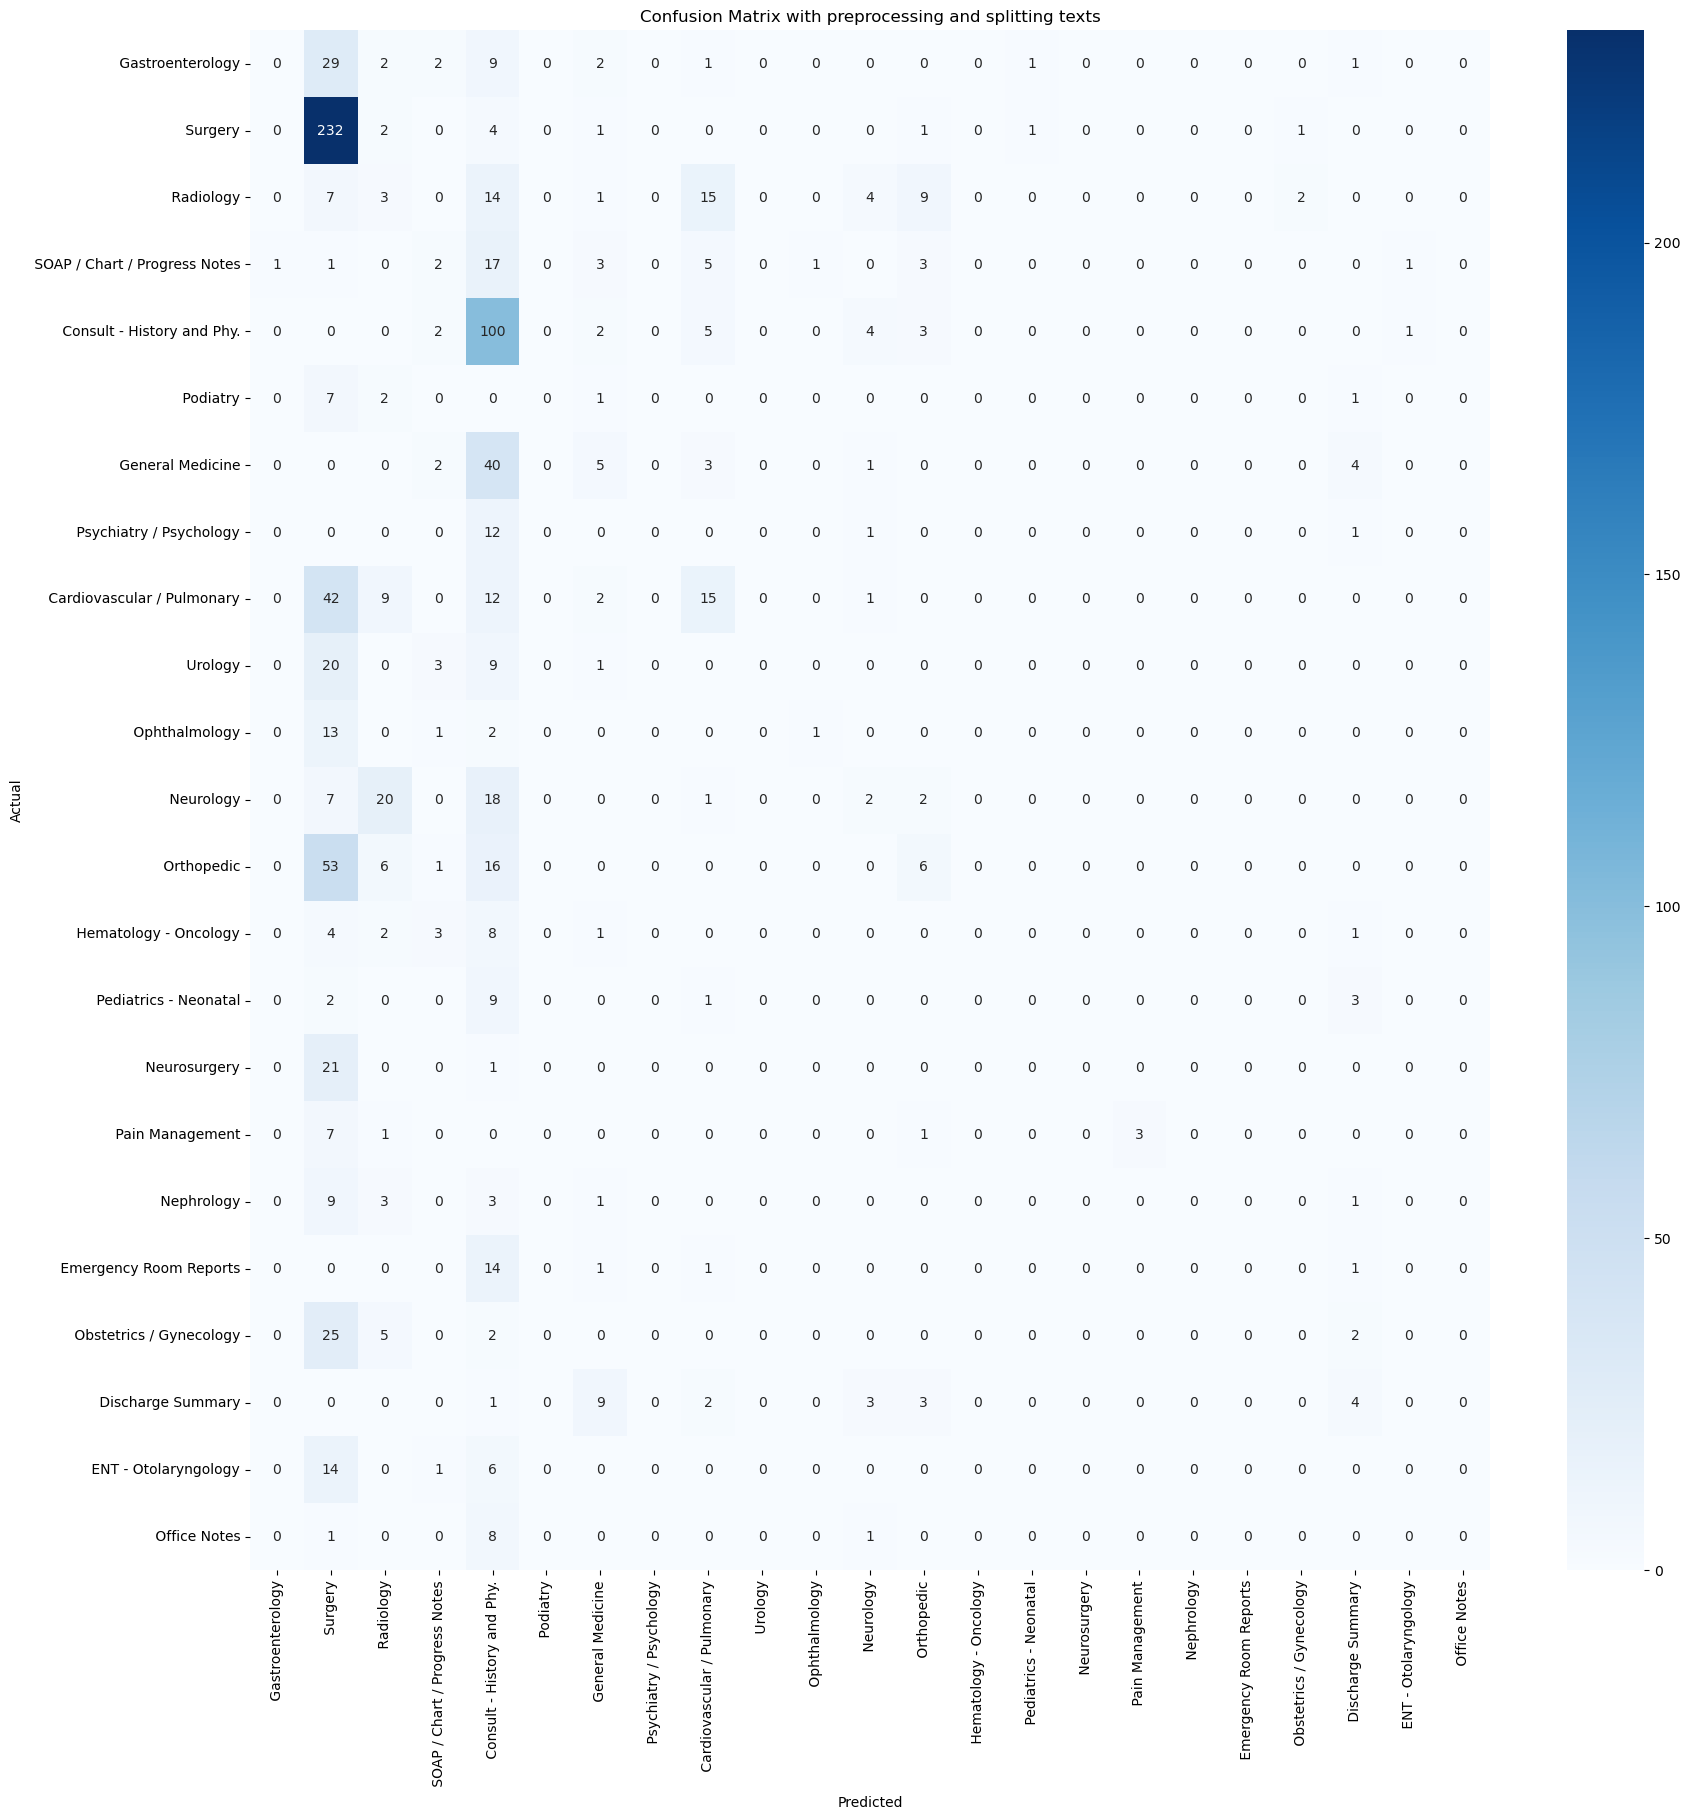

In [55]:
# Assuming true_labels and predictions are your labels and predictions
cm = confusion_matrix(y_test_split_pp, preds_split_pp)

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=idx2label.values(),
    yticklabels=idx2label.values(),
)
plt.title("Confusion Matrix with preprocessing and splitting texts")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()